In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


In [189]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt

# Utils

In [3]:
def load_text(path):
    # read the file
    with open(path, 'r') as file:
        text = file.read()
    return text

In [119]:
def get_line_starts_with(s, start):
    s = s.split('\n')
    for line in s:
        if line.find(start) == 0:
            return line

# Depth Poset Scores

## Logs

In [4]:
# path to log-files
path_logs_scores = 'logs/scores_on_cubical_torus'

# define path for each log-file
df_logs_scores = pd.DataFrame({'log-path': os.listdir(path_logs_scores)})
df_logs_scores['log-path'] = df_logs_scores['log-path'].apply(lambda s: os.path.join(path_logs_scores, s))
df_logs_scores = df_logs_scores[df_logs_scores['log-path'].apply(lambda s: Path(s).suffix) == '.log']

# define job index
df_logs_scores['job'] = df_logs_scores['log-path'].apply(lambda s: s[36:-4])

# load logs
df_logs_scores['log'] = df_logs_scores['log-path'].apply(load_text)

# define status
df_logs_scores['completed'] = df_logs_scores['log'].apply(lambda s: s.find('The result is saved to path') != -1)
df_logs_scores['time-limit'] = df_logs_scores['log'].apply(lambda s: s.find('slurmstepd') == 0)
df_logs_scores['out-of-memory'] = df_logs_scores['log'].apply(lambda s: s.find('out-of-memory') != -1)
assert (df_logs_scores[['completed', 'time-limit', 'out-of-memory']].sum(axis=1) <= 1).all()
df_logs_scores['status'] = df_logs_scores[['completed', 'time-limit', 'out-of-memory']].idxmax(axis=1).where(df_logs_scores[['completed', 'time-limit', 'out-of-memory']].any(axis=1), 'other')


print(f'df_logs_scores.shape = {df_logs_scores.shape}')
df_logs_scores.head()

df_logs_scores.shape = (217, 7)


,log-path,job,log,completed,time-limit,out-of-memory,status
0,logs/scores_on_cubical_torus/output_36624779.log,36624779,slurmstepd-zeta260: error: *** JOB 36624779 ON...,False,True,False,time-limit
1,logs/scores_on_cubical_torus/output_36624782.log,36624782,slurmstepd-zeta262: error: *** JOB 36624782 ON...,False,True,False,time-limit
2,logs/scores_on_cubical_torus/output_36624891.log,36624891,slurmstepd-eta372: error: *** JOB 36624891 ON ...,False,True,False,time-limit
3,logs/scores_on_cubical_torus/output_36624791.log,36624791,slurmstepd-serbyn129: error: *** JOB 36624791 ...,False,True,False,time-limit
4,logs/scores_on_cubical_torus/output_36624888.log,36624888,/var/lib/slurm/slurmd/job36624888/slurm_script...,False,False,True,out-of-memory


In [5]:
df_logs_scores['status'].value_counts()

status
time-limit       107
completed         77
out-of-memory     31
other              2
Name: count, dtype: int64

In [6]:
print(df_logs_scores[df_logs_scores['time-limit']]['log'].iloc[0])

slurmstepd-zeta260: error: *** JOB 36624779 ON zeta260 CANCELLED AT 2025-07-01T15:17:50 DUE TO TIME LIMIT ***



In [7]:
print(df_logs_scores[df_logs_scores['out-of-memory']]['log'].iloc[0])

/var/lib/slurm/slurmd/job36624888/slurm_script: line 18: 3836214 Killed                  python scripts/calculate_scores_on_cubical_torus.py $dim $n
slurmstepd-eta338: error: Detected 1 oom-kill event(s) in StepId=36624888.batch. Some of your processes may have been killed by the cgroup out-of-memory handler.



__Сonclusion:__ The logs are empty, when the process have been failed. So we can't conclude about the dependency of dimension/size and the fail reason.

__Solution:__ Next time we should start script with `-u` parameter:
```bash
python -u scripts/calculate_scores_on_cubical_torus.py $dim $n
```

In [8]:
def get_gim(s):
    d = s.replace('Calculate the scores for the barycentric model on the', '')
    d = d[:d.find('-')]
    try:
        d = int(d)
        return d
    except ValueError:
        return None

In [9]:
def get_n(s):
    try:
        d = s.split('\n')[0].split(' ')[-2]
        d = int(d)
        return d
    except Exception:
        return None

In [36]:
df_logs_scores['dim'] = df_logs_scores['log'].apply(get_gim).astype('Int32')
df_logs_scores['n'] = df_logs_scores['log'].apply(get_n).astype('Int32')

df_logs_scores[['status', 'dim', 'n']].value_counts(dropna=False).reset_index()#.pivot_table(columns='status', index=['dim', 'n'], values='count', dropna=False).fillna(0).astype(int)

,status,dim,n,count
0,time-limit,<NA>,<NA>,107
1,out-of-memory,<NA>,<NA>,31
2,completed,1,40,10
3,completed,1,64,10
4,completed,1,56,10
5,completed,1,68,10
6,completed,1,72,10
7,completed,1,80,10
8,completed,1,76,10
9,completed,2,32,7


## Parameters

In [53]:
path_params_scores = 'params/scores_on_cubical_torus.txt'

with open(path_params_scores, 'r') as file:
    df_params_scores = file.read()

df_params_scores = [s.split() for s in df_params_scores.split('\n')]
df_params_scores = pd.DataFrame(data=df_params_scores, columns=['dim', 'n']).astype('Int32')

print(f'df_params_scores.shape = {df_params_scores.shape}')
df_params_scores.head()

df_params_scores.shape = (218, 2)


,dim,n
0,1,40
1,1,40
2,1,40
3,1,40
4,1,40


In [65]:
df_total_scores = df_params_scores.value_counts(dropna=False).reset_index().rename(columns={'count': 'params'}).set_index(['dim', 'n'])
df_total_scores = df_total_scores.merge(df_logs_scores[['dim', 'n', 'status']].value_counts(dropna=False).reset_index().pivot_table(index=['dim', 'n'], columns='status', values='count', dropna=False).fillna(0).astype(int), 
                                        on=['dim', 'n'], how='left')
df_total_scores[pd.unique(df_logs_scores['status'])] = df_total_scores[pd.unique(df_logs_scores['status'])].fillna(0).astype(int)

df_total_scores

params  completed  other  out-of-memory  time-limit
dim  n                                                        
1    40        10         10      0              0           0
     56        10         10      0              0           0
     64        10         10      0              0           0
     68        10         10      0              0           0
     72        10         10      0              0           0
     76        10         10      0              0           0
     80        10         10      0              0           0
2    32        10          7      0              0           0
     36        10          0      0              0           0
     40        10          0      0              0           0
     44        10          0      0              0           0
     48        10          0      0              0           0
     52        10          0      0              0           0
3    7         10          0      0              0           0
     8         10          0      0              0           0
4    3         10          0      0              0           0
3    9         10          0      0              0           0
     10        10          0      0              0           0
     11        10          0      0              0           0
4    5         10          0      0              0           0
     4         10          0      0              0           0
3    6          7          0      0              0           0
<NA> <NA>       1          0      2             31         107

In [73]:
(df_total_scores['params'] - df_total_scores[pd.unique(df_logs_scores['status'])].sum(axis=1))

dim   n   
1     40        0
      56        0
      64        0
      68        0
      72        0
      76        0
      80        0
2     32        3
      36       10
      40       10
      44       10
      48       10
      52       10
3     7        10
      8        10
4     3        10
3     9        10
      10       10
      11       10
4     5        10
      4        10
3     6         7
<NA>  <NA>   -139
dtype: int64

# Transpositions


## Logs

In [146]:
def get_torus_dim_and_size(path):
    with open(path, 'rb') as file:
        data = pkl.load(file)
    dim = data['dim']
    n = data['shape'][0]
    return dim, n

In [187]:
# path to log-files
path_logs_transp = 'logs/transpositions_during_homotopies_between_cubical_toruses'

# define path for each log-file
df_logs_transp = pd.DataFrame({'log-path': os.listdir(path_logs_transp)})
df_logs_transp['log-path'] = df_logs_transp['log-path'].apply(lambda s: os.path.join(path_logs_transp, s))
df_logs_transp = df_logs_transp[df_logs_transp['log-path'].apply(lambda s: Path(s).suffix) == '.log']

# get job index
df_logs_transp['job'] = df_logs_transp['log-path'].apply(lambda s: s[-12:-4])

# load logs
df_logs_transp['log'] = df_logs_transp['log-path'].apply(load_text)

# get task id
assert df_logs_transp['log'].apply(lambda s: s.find('SLURM_ARRAY_TASK_ID') != -1).all()
df_logs_transp['task-id'] = df_logs_transp['log'].apply(lambda s: get_line_starts_with(s, 'SLURM_ARRAY_TASK_ID')[23:-1])
df_logs_transp['task-id'] = df_logs_transp['task-id'].astype(int)

# get paths to filtrations
assert df_logs_transp['log'].apply(lambda s: s.find('path0') != -1).all()
assert df_logs_transp['log'].apply(lambda s: s.find('path1') != -1).all()
df_logs_transp['path0'] = df_logs_transp['log'].apply(lambda s: get_line_starts_with(s, 'path0')[6:])
df_logs_transp['path1'] = df_logs_transp['log'].apply(lambda s: get_line_starts_with(s, 'path1')[6:])

df_logs_transp['size0'] = df_logs_transp['path0'].apply(lambda path: os.path.getsize(path) if os.path.exists(path) else None)
df_logs_transp['size1'] = df_logs_transp['path1'].apply(lambda path: os.path.getsize(path) if os.path.exists(path) else None)

# get the shapes of input tori
df_logs_transp['dim&n'] = df_logs_transp['path0'].apply(lambda path: get_torus_dim_and_size(path) if os.path.exists(path) else (None, None))
df_logs_transp['dim'] = df_logs_transp['dim&n'].apply(lambda i: i[0]).astype('Int32')
df_logs_transp['n'] = df_logs_transp['dim&n'].apply(lambda i: i[1]).astype('Int32')
df_logs_transp = df_logs_transp.drop(columns='dim&n')

# get status
df_logs_transp['completed'] = df_logs_transp['log'].apply(lambda s: s.find('The result is saved to path:') != -1)
df_logs_transp['out-of-memory'] = df_logs_transp['log'].apply(lambda s: s.find('out-of-memory') != -1)
df_logs_transp['time-limit'] = df_logs_transp['log'].apply(lambda s: s.find('TIME LIMIT') != -1)
assert (df_logs_transp[['completed', 'time-limit', 'out-of-memory']].sum(axis=1) <= 1).all()
df_logs_transp['status'] = df_logs_transp[['completed', 'time-limit', 'out-of-memory']].idxmax(axis=1).where(df_logs_transp[['completed', 'time-limit', 'out-of-memory']].any(axis=1), 'other')

print(f'df_logs_transp.shape = {df_logs_transp.shape}')
df_logs_transp.head()

df_logs_transp.shape = (1938, 14)


,log-path,job,log,task-id,path0,path1,size0,size1,dim,n,completed,out-of-memory,time-limit,status
0,logs/transpositions_during_homotopies_between_...,36704916,"SLURM_ARRAY_TASK_ID = '1681'\nLINE: ""results/s...",1681,results/scores-on-barycentric-cubical-toruses/...,results/scores-on-barycentric-cubical-toruses/...,56747.0,56819.0,2,12,False,True,False,out-of-memory
1,logs/transpositions_during_homotopies_between_...,36695460,"SLURM_ARRAY_TASK_ID = '756'\nLINE: ""results/sc...",756,results/scores-on-barycentric-cubical-toruses/...,results/scores-on-barycentric-cubical-toruses/...,15145.0,15124.0,2,4,True,False,False,completed
2,logs/transpositions_during_homotopies_between_...,36693121,"SLURM_ARRAY_TASK_ID = '334'\nLINE: ""results/sc...",334,results/scores-on-barycentric-cubical-toruses/...,results/scores-on-barycentric-cubical-toruses/...,7499.0,7511.0,1,10,True,False,False,completed
3,logs/transpositions_during_homotopies_between_...,36695906,"SLURM_ARRAY_TASK_ID = '833'\nLINE: ""results/sc...",833,results/scores-on-barycentric-cubical-toruses/...,results/scores-on-barycentric-cubical-toruses/...,15482.0,15497.0,1,40,True,False,False,completed
4,logs/transpositions_during_homotopies_between_...,36701227,"SLURM_ARRAY_TASK_ID = '1390'\nLINE: ""results/s...",1390,results/scores-on-barycentric-cubical-toruses/...,results/scores-on-barycentric-cubical-toruses/...,25706.0,25836.0,2,7,True,False,False,completed


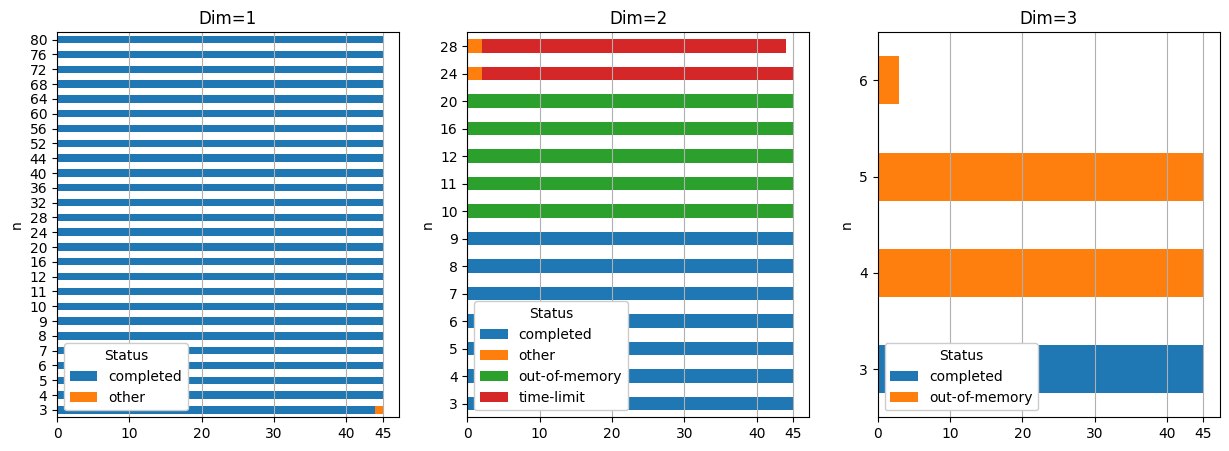

In [221]:
df_logs_transp_stats = df_logs_transp[['dim', 'n', 'status']].value_counts(dropna=False).reset_index().pivot_table(index=['n'], columns=['dim', 'status'], values='count', dropna=True)

dims = df_logs_transp_stats.columns.get_level_values(0).unique()
fig, axs = plt.subplots(1, len(dims), figsize=(15, 5))

for i, dim in enumerate(dims):
    axs[i].set_title(f'Dim={dim}')
    df_to_plot = df_logs_transp_stats[dim]
    df_to_plot = df_to_plot.dropna(how='all').fillna(0)
    df_to_plot.plot(kind='barh', stacked=True, ax=axs[i])
    axs[i].legend(loc='lower left', title='Status', framealpha=1)

    xticks = axs[i].get_xticks()
    xticks = xticks[xticks < df_to_plot.max().max()]
    xticks = np.append(xticks, df_to_plot.max().max())
    axs[i].set_xticks(xticks)
    axs[i].grid(axis='x')

## Parameters

In [274]:
path_params_transp = 'params/transpositions_during_homotopies_between_cubical_toruses.txt'

with open(path_params_transp, 'r') as file:
    df_params_transp = file.read()

df_params_transp = [s.split('" "') for s in df_params_transp.split('\n')]
df_params_transp = pd.DataFrame(data=df_params_transp, columns=['path0', 'path1']).applymap(lambda s: s.strip('"') if s is not None else None)
#df_params_transp.index.name = 'task-id'

# check if this task loged
df_params_transp['loged'] = df_params_transp.index.isin(df_logs_transp['task-id'] - 1)

# check id
df_params_transp = df_params_transp.merge(df_logs_transp, on=['path0', 'path1'], how='left')
assert ((df_params_transp.index == df_params_transp['task-id'] - 1)|(~df_params_transp['loged'])).all()


print(f'df_params_transp.shape = {df_params_transp.shape}')
df_params_transp.head()

df_params_transp.shape = (1939, 15)


/tmp/ipykernel_11419/1327482606.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_params_transp = pd.DataFrame(data=df_params_transp, columns=['path0', 'path1']).applymap(lambda s: s.strip('"') if s is not None else None)


,path0,path1,loged,log-path,job,log,task-id,size0,size1,dim,n,completed,out-of-memory,time-limit,status
0,results/scores-on-barycentric-cubical-toruses/...,results/scores-on-barycentric-cubical-toruses/...,True,logs/transpositions_during_homotopies_between_...,36647019,"SLURM_ARRAY_TASK_ID = '1'\nLINE: ""results/scor...",1.0,2439.0,2439.0,1,3,True,False,False,completed
1,results/scores-on-barycentric-cubical-toruses/...,results/scores-on-barycentric-cubical-toruses/...,True,logs/transpositions_during_homotopies_between_...,36647119,"SLURM_ARRAY_TASK_ID = '2'\nLINE: ""results/scor...",2.0,2439.0,2439.0,1,3,True,False,False,completed
2,results/scores-on-barycentric-cubical-toruses/...,results/scores-on-barycentric-cubical-toruses/...,True,logs/transpositions_during_homotopies_between_...,36647222,"SLURM_ARRAY_TASK_ID = '3'\nLINE: ""results/scor...",3.0,2439.0,2439.0,1,3,True,False,False,completed
3,results/scores-on-barycentric-cubical-toruses/...,results/scores-on-barycentric-cubical-toruses/...,True,logs/transpositions_during_homotopies_between_...,36647323,"SLURM_ARRAY_TASK_ID = '4'\nLINE: ""results/scor...",4.0,2439.0,2446.0,1,3,True,False,False,completed
4,results/scores-on-barycentric-cubical-toruses/...,results/scores-on-barycentric-cubical-toruses/...,True,logs/transpositions_during_homotopies_between_...,36647425,"SLURM_ARRAY_TASK_ID = '5'\nLINE: ""results/scor...",5.0,2439.0,2446.0,1,3,True,False,False,completed


In [286]:
df_params_transp[~df_params_transp['loged']][['path0', 'path1']]

,path0,path1
1937,results/scores-on-barycentric-cubical-toruses/...,results/scores-on-barycentric-cubical-toruses/...
1938,,None
